In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from unidecode import unidecode

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.linear_model import Ridge

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

%load_ext autoreload
%autoreload 2

### 1. Read wheat and weather data

In [25]:
wheat = pd.read_csv("data/crop/national_yield_detrended.csv")
era = pd.read_csv("data/features/era_basis_expansion_features_1993_2016.csv")
era_yield = era.merge(wheat, on="year")
era_yield = era_yield.loc[era_yield["year"].between(1993, 2016)].reset_index(drop=True)

# read subnational wheat series and store unique region names
#relevant_areas = pd.read_csv("data/crop/subnational_yield_with_trend.csv")["name"].unique()

### 2. Identify relevant locations for weather features

- There are more than 100 municipalities with tmean and rainfall data
- Using LOYO-CV, we train national wheat yield forecast models for each municipality
- The weather data from the best performing municipalities is used and the other data is dropped

In [26]:
def forecast_of_areas(data, r2_threshold):
    """
    fits a national yield model for each area and returns best performances as dictionary
    params: 
        data: dataframe, with features from all municipalities
        r2_threshold: float, definition of a well-performing area
    returns:
        area_to_r2: dictionary, with keys being the municipalities and values the best model that could be fit
    """
    area_to_r2 = {}
    municipalities = list(set([c.split("_")[1] if c not in ['year', 'harvested area [ha]', 'yield [kg/ha]', 'yield_trend [kg/ha]', 'yield anomaly [%]'] else 'santa fe san cristobal' for c in data.columns]))
    for area in municipalities:
        best_r2 = r2_threshold
        for no_of_features in list(range(1,7)):
            # split
            X = data.loc[:, [c for c in [l for l in data.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] == area]]
            y = data["yield anomaly [%]"]

            # pipeline object for regression model
            pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=no_of_features)), ('estimator', Ridge())])
            
            # Perform LOOCV and obtain predictions
            loo = LeaveOneOut()
            y_pred = cross_val_predict(pipeline, X, y, cv=loo)

            # Calculate metrics
            current_r2 = np.round(r2_score(y, y_pred), 4)

            if current_r2 > best_r2:
                print("R2 {}; area {}; features {}".format(current_r2, area, no_of_features))
                best_r2 = current_r2
                area_to_r2[area] = current_r2

    return area_to_r2

In [27]:
areas_to_r2 = forecast_of_areas(era_yield, 0.0)

R2 0.3059; area buenos aires saavedra; features 1
R2 0.1386; area buenos aires tornquist; features 1
R2 0.1869; area buenos aires tornquist; features 2
R2 0.0335; area entre rios colon; features 3
R2 0.0173; area santa fe las colonias; features 1
R2 0.037; area santa fe las colonias; features 2
R2 0.1002; area santa fe las colonias; features 4
R2 0.2127; area santa fe las colonias; features 5
R2 0.0069; area buenos aires daireaux; features 1
R2 0.2394; area buenos aires daireaux; features 3
R2 0.0224; area santa fe san cristobal; features 5
R2 0.285; area buenos aires coronel pringles; features 1
R2 0.204; area buenos aires laprida; features 1
R2 0.2169; area entre rios nogoya; features 1
R2 0.2121; area entre rios gualeguaychu; features 1
R2 0.1689; area entre rios tala; features 1
R2 0.0581; area buenos aires bahia blanca; features 2
R2 0.1726; area entre rios uruguay; features 1
R2 0.2964; area buenos aires general la madrid; features 1
R2 0.0158; area buenos aires adolfo alsina; fe

In [28]:
sorted_area_names = sorted(areas_to_r2, key=areas_to_r2.get, reverse=True)
sorted_area_names

['buenos aires coronel suarez',
 'buenos aires hipolito yrigoyen',
 'buenos aires saavedra',
 'buenos aires general la madrid',
 'buenos aires coronel pringles',
 'santa fe san justo',
 'buenos aires trenque lauquen',
 'buenos aires daireaux',
 'entre rios nogoya',
 'santa fe las colonias',
 'entre rios gualeguaychu',
 'buenos aires laprida',
 'buenos aires tornquist',
 'entre rios parana',
 'entre rios uruguay',
 'entre rios tala',
 'buenos aires puan',
 'buenos aires pehuajo',
 'santa fe la capital',
 'buenos aires bahia blanca',
 'entre rios colon',
 'santa fe san cristobal',
 'buenos aires adolfo alsina',
 'entre rios diamante']

In [29]:
print("The best performance comes from: \n{}".format("', '".join(list(areas_to_r2.keys()))))

The best performance comes from: 
buenos aires saavedra', 'buenos aires tornquist', 'entre rios colon', 'santa fe las colonias', 'buenos aires daireaux', 'santa fe san cristobal', 'buenos aires coronel pringles', 'buenos aires laprida', 'entre rios nogoya', 'entre rios gualeguaychu', 'entre rios tala', 'buenos aires bahia blanca', 'entre rios uruguay', 'buenos aires general la madrid', 'buenos aires adolfo alsina', 'buenos aires hipolito yrigoyen', 'entre rios parana', 'santa fe la capital', 'buenos aires puan', 'entre rios diamante', 'buenos aires coronel suarez', 'buenos aires pehuajo', 'santa fe san justo', 'buenos aires trenque lauquen


#### Filter features 


In [30]:
selected_areas = list(areas_to_r2.keys())
era_yield_filtered = era_yield.loc[:, ["yield anomaly [%]", "yield [kg/ha]", "year"] + [c for c in [l for l in era_yield.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[1] in selected_areas]]

# order columns by performance
new_column_order = ["year", "yield anomaly [%]", "yield [kg/ha]"]
for area in sorted_area_names:
    area_columns = [c for c in era_yield_filtered.columns if area in c]
    new_column_order = new_column_order + area_columns
era_yield_filtered = era_yield_filtered[new_column_order]
era_yield_filtered.head()

,year,yield anomaly [%],yield [kg/ha],tmeansquared_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_10,tmeansquared_buenos aires coronel suarez_11,rainsquared_buenos aires coronel suarez_9,rainsquared_buenos aires coronel suarez_10,rainsquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_9,...,tmeanrain_buenos aires adolfo alsina_11,tmeansquared_entre rios diamante_9,tmeansquared_entre rios diamante_10,tmeansquared_entre rios diamante_11,rainsquared_entre rios diamante_9,rainsquared_entre rios diamante_10,rainsquared_entre rios diamante_11,tmeanrain_entre rios diamante_9,tmeanrain_entre rios diamante_10,tmeanrain_entre rios diamante_11
0,1993,-0.046171,2037.439151,-0.819150,-0.391620,0.286323,-0.640213,-0.506081,0.217259,0.507882,...,-3.798351,2.045004,-0.594647,0.093547,0.033838,12.399867,-0.647179,2.050190,-2.942046,-0.232278
1,1994,0.018138,2185.741998,-0.752390,-0.041853,-0.092845,-0.172277,-0.685709,0.369163,-0.031891,...,-0.605213,0.285663,-0.516436,-0.321771,-0.762493,-0.379314,-0.444081,-0.498254,-0.087273,0.268636
2,1995,-0.102265,1946.759707,0.993220,-0.416686,-0.497664,0.308811,-0.462868,0.374048,-1.346638,...,0.494326,-0.340720,0.253976,-0.283275,-0.762833,-0.391592,-0.795991,-0.358521,0.732177,0.276576
3,1996,0.040968,2260.470320,-1.034622,-0.149350,-0.416771,-0.055912,-0.750778,-0.243913,0.492462,...,1.186958,-0.744110,-0.722396,-0.283442,5.243249,-0.398368,-0.661938,-1.160506,0.110707,0.353229
4,1997,0.175913,2623.252920,0.167093,-0.196796,0.065018,-0.601648,-0.355888,-0.147146,0.760139,...,1.360580,-0.860215,-0.655888,-0.282267,-0.245850,-0.347646,-0.545044,-0.296477,-0.057889,0.039393


### 4. Train and validate national model

In [31]:
def train_and_validate_national_model(data, corr_threshold, no_features, alpha):
    """
    apply LOYO-CV on data.
    params:
        data: dataframe, contains features and targets
        corr_threshold: float, to filter correlated features before model fit
        no_features: int, number of features to train the model on
    return (as tuple):
        features: dictionary, all features that have been selected for all folds
        rmse, current_r2, pearson_r: float, performance metrics
        y_pred, y: list, predictions and ground truth
    """
    features = {}
    # feature-target split
    X = data.loc[:, [c for c in data.columns if ("rain" in c) or ("tmean" in c)]]
    y = data["yield anomaly [%]"]

    # remove spatially-correlated features
    X_tmean_squared = X.loc[:, [c for c in X.columns if ("tmeansquared" in c)]]
    X_rain_squared = X.loc[:, [c for c in X.columns if ("rainsquared" in c)]]
    X_tmean_rain = X.loc[:, [c for c in X.columns if ("tmeanrain" in c)]]
    feature_sets = [X_tmean_squared, X_rain_squared, X_tmean_rain]
    to_drop =[]
    for feature_set in feature_sets:
        for month in [9, 10, 11]:
            feature_set_month = feature_set.loc[:, [c for c in feature_set.columns if (c.split("_")[-1] == str(month))]]
            cor_matrix = feature_set_month.corr().abs().round(2)
            upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
            #print(upper_tri)
            #print([column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)])
            to_drop.append([column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)])
    to_drop = [c for k in to_drop for c in k]
    X = X.drop(to_drop, axis=1)
    
    # pipeline object for regression model
    pipeline = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(f_regression, k=no_features)), ('estimator', Ridge(alpha=alpha))])

    # Perform LOOCV and obtain predictions
    loo = LeaveOneOut()
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)

    output = cross_validate(pipeline, X, y, scoring="neg_mean_squared_error", cv=loo, return_estimator=True)
    for idx,estimator in enumerate(output['estimator']):
        selected_features = estimator.named_steps["selector"].get_feature_names_out(X.columns).tolist()
        features[idx] = selected_features
    #features = [c.tolist() for c in features]   
    #features = list(set([item for sublist in [c.tolist() for c in features] for item in sublist]))
    rmse = np.round(mse(y, y_pred, squared=False), 4)
    current_r2 = np.round(r2_score(y, y_pred), 4)
    pearson_r = np.round(pearsonr(y, y_pred)[0], 2)

    return (features, rmse, current_r2, pearson_r, y_pred, y)

In [32]:
# rmse is 0.078, r2 is 0.67 for corr_threshold 0.6 and 7 features
best_rmse = 0.12
best_r2 = 0
#feature_list = []
for alpha in [1]:
    for c in [.5, .6, .7, .8]:
        for f in [3, 4, 5, 6, 7]:
            features, rmse, current_r2, _, y_pred, y = train_and_validate_national_model(era_yield_filtered, c, f, alpha)
            if rmse < best_rmse: 
                print("rmse is {}, r2 is {} for corr_threshold {}, {} features and {} alpha".format(rmse, current_r2, c, f, alpha))
                best_r2 = current_r2
                best_rmse = rmse
                feature_list = features
                best_corr = c
                best_f_no = f

relevant_features = list(set([item for sublist in list(feature_list.values()) for item in sublist]))
relevant_features

rmse is 0.0834, r2 is 0.6193 for corr_threshold 0.5, 3 features and 1 alpha
rmse is 0.0805, r2 is 0.6449 for corr_threshold 0.6, 6 features and 1 alpha
rmse is 0.0779, r2 is 0.6678 for corr_threshold 0.6, 7 features and 1 alpha
rmse is 0.0728, r2 is 0.7099 for corr_threshold 0.7, 5 features and 1 alpha
rmse is 0.0706, r2 is 0.7273 for corr_threshold 0.7, 6 features and 1 alpha


['tmeanrain_santa fe san justo_10',
 'tmeanrain_entre rios nogoya_10',
 'tmeanrain_buenos aires coronel suarez_11',
 'tmeanrain_buenos aires hipolito yrigoyen_11',
 'rainsquared_santa fe las colonias_11',
 'rainsquared_santa fe san justo_11',
 'rainsquared_buenos aires hipolito yrigoyen_9',
 'tmeansquared_buenos aires coronel suarez_11',
 'tmeanrain_santa fe san justo_11']

#### Analyse multicollinearity of best model

Check if all folds had valid solutions, where the selected features have multicollinearity (measured as variance inflation factor) of around 5:

In [10]:
def calculate_variance_inflation_factor(data):
    """
    calculate variance inflation factor.
    params:
        data: dataframe, containing all features
    returns:
        vif_series: series, wit the VIF for each variable
    """
    VIF = add_constant(data)
    result = pd.Series([variance_inflation_factor(VIF.values, i) 
                for i in range(VIF.shape[1])], 
                index=VIF.columns)
    return result

max_vif = 0
for fold in feature_list:
    result = calculate_variance_inflation_factor(era_yield_filtered[feature_list[fold]])
    vif_result = np.round(result.loc[~result.index.str.contains("const")].max(), 2)
    if vif_result > max_vif:
        print(vif_result)
        max_vif = vif_result

2.95
5.6


### 5. Visualize estimates

In [11]:
relevant_features

['tmeansquared_buenos aires coronel suarez_11',
 'rainsquared_santa fe las colonias_11',
 'rainsquared_buenos aires hipolito yrigoyen_9',
 'tmeanrain_buenos aires hipolito yrigoyen_11',
 'tmeanrain_buenos aires coronel suarez_11',
 'tmeanrain_entre rios nogoya_10',
 'tmeanrain_santa fe san justo_11',
 'rainsquared_santa fe san justo_11',
 'tmeanrain_santa fe san justo_10']

In [15]:
gdf_adm1 = gpd.read_file("data/shapefile/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")
gdf_adm2 = gpd.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]

# filter areas 
#gdf_adm1 = gdf_adm1.loc[gdf_adm1["ADM1_ES"].isin(["Buenos Aires", "La Pampa", "Córdoba", "Entre Ríos", "Santa Fe"]), ["ADM1_ES", "geometry"]].reset_index(drop=True)
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(list(set([c.split("_")[1] for c in relevant_features]))), ["name", "geometry"]].reset_index(drop=True)

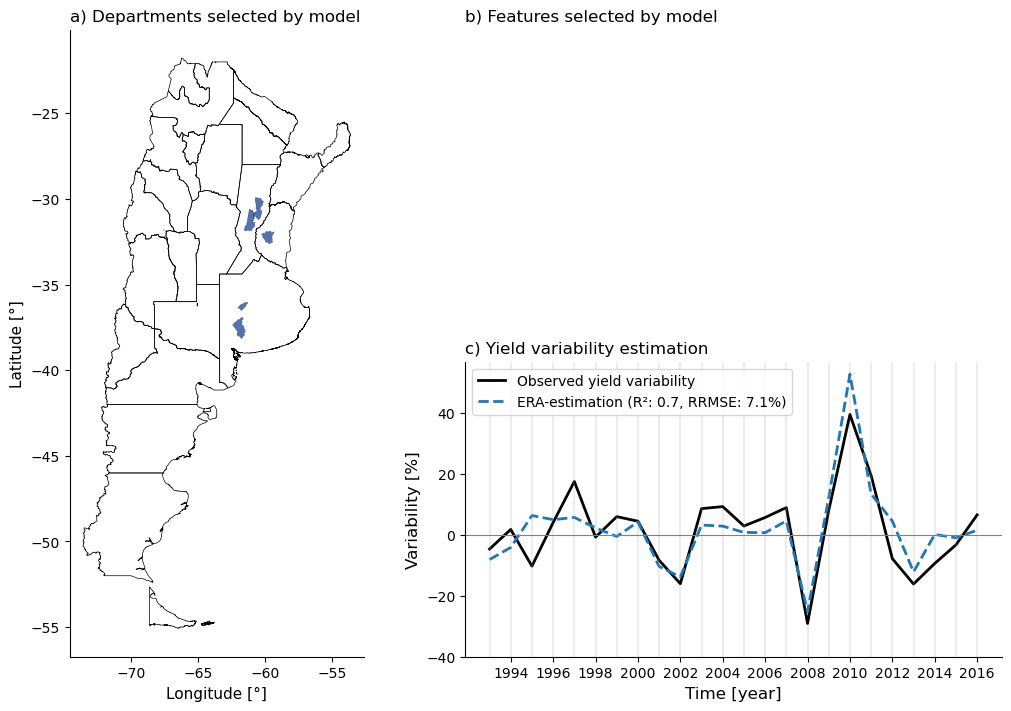

In [25]:
"""
For absolute yield:
z = x_y_cv_filtered["year"].apply(lambda x: years_to_params[x]["slope"] * x + years_to_params[x]["bias"])
x_y_cv_filtered["yield [t/ha]"] = x_y_cv_filtered["yield [kg/ha]"].apply(lambda x: np.round(x/1000, 2))
y_pred = (y_pred * z + z) / 1000
with years_to_params dictionary from notebook "2_prepare_era_data.ipynb"
"""

# Create subplots
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(10, 7), layout="constrained", width_ratios=[0.4, 0.6])


# Figure a) Study region
gdf_adm2.plot(ax=axd["left"], color="#5273B2", edgecolor="black", linewidth=.1)
gdf_adm1.plot(ax=axd["left"], color="#FF000000", edgecolor="black", linewidth=.5)
axd['left'].set_title("a) Departments selected by model", loc="left", size=12);
axd['left'].set_ylabel("Latitude [°]", size=11);
axd['left'].set_xlabel("Longitude [°]", size=11);
axd['left'].spines[['right', 'top']].set_visible(False)

loc2 = "upper right"
axd[loc2].set_title("b) Features selected by model", loc="left");
axd[loc2].axis("off")

(features, rmse, current_r2, pearson_r, y_pred, y) = train_and_validate_national_model(era_yield_filtered, best_corr, best_f_no, 2)
y = 100*y
y_pred_new = 100*y_pred

loc3 = "lower right"
axd[loc3].plot(era_yield_filtered["year"], y, color="black", label="Observed yield variability", linewidth=2);
axd[loc3].plot(era_yield_filtered["year"], y_pred_new, linestyle="dashed", label="ERA-estimation (R\u00b2: {}, RRMSE: {}%)".format(round(best_r2, 1), round(100*best_rmse, 1)), linewidth=2);
axd[loc3].set_ylabel("Variability [%]", size=12)
axd[loc3].set_title("c) Yield variability estimation", loc="left", size=12);
axd[loc3].set_xlabel("Time [year]", size=12)
axd[loc3].set_xticks(list(range(1994, 2017, 2)))
axd[loc3].grid(axis="x", linewidth=.3, color="#A8A8A8")
axd[loc3].set_yticks([40, 20, 0, -20, -40])
xcoords = list(range(1993, 2016, 2))
for xc in xcoords:
    axd[loc3].axvline(x=xc, linewidth=.3, color="#A8A8A8")
axd[loc3].spines[['right', 'top']].set_visible(False)
axd[loc3].axhline(0, 0, color="grey", linewidth=.8)
axd[loc3].legend(loc="upper left");

#plt.savefig("figures/figure2.svg")
plt.show();

### Filter by selected features

In [26]:
era_yield_filtered_features = era_yield_filtered.assign(model="ERA", init_month=12).set_index(["model", "year", "init_month", "yield [kg/ha]", "yield anomaly [%]"])[relevant_features].reset_index(drop=False)
#era_yield_filtered_features.columns = [c.replace("buenos aires ", "") for c in era_yield_filtered_features.columns]
era_yield_filtered_features.head()

,model,year,init_month,yield [kg/ha],yield anomaly [%],tmeansquared_buenos aires coronel suarez_11,rainsquared_santa fe las colonias_11,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires hipolito yrigoyen_11,tmeanrain_buenos aires coronel suarez_11,tmeanrain_entre rios nogoya_10,tmeanrain_santa fe san justo_11,rainsquared_santa fe san justo_11,tmeanrain_santa fe san justo_10
0,ERA,1993,12,2037.439151,-0.046171,0.286323,0.051609,-0.504002,-2.834841,-1.337138,-0.834527,-1.042311,0.045925,-2.845167
1,ERA,1994,12,2185.741998,0.018138,-0.092845,-0.488864,-0.515184,-0.945870,-1.033729,-0.736548,0.355199,-0.672357,-1.192060
2,ERA,1995,12,1946.759707,-0.102265,-0.497664,-0.826273,-0.219249,0.626355,0.406637,0.392497,-0.019850,-0.806254,0.204602
3,ERA,1996,12,2260.470320,0.040968,-0.416771,-0.770822,-0.254815,0.095711,0.436535,-0.257358,0.315138,-0.677612,0.002081
4,ERA,1997,12,2623.252920,0.175913,0.065018,-0.747324,-0.440915,-0.982564,0.979243,-0.187273,0.145713,-0.825750,0.065824


### 6. Export datasets

In [27]:
#era_yield_filtered_features.to_csv("data/features/era_features_filtered_case12.csv", index=False)

### ERA standardized 1993-2022


**R2 threshold: 0.0, 0.1**

**CASE 1**: best performing model with rmse is 0.0575, r2 is 0.8191 for corr_threshold 0.7 and 7 features

**CASE 2**: best performing model with rmse is 0.0632, r2 is 0.7817 for corr_threshold 0.7 and 6 features

**CASE 3**: best performing model with rmse is 0.0657, r2 is 0.7638 for corr_threshold 0.6 and 6 features

**CASE 4**: best performing model with rmse is 0.0698, r2 is 0.7335 for corr_threshold 0.6 and 5 features

**R2 threshold of 0.2, 0.3**

**CASE 5**: rmse is 0.0592, r2 is 0.8084 for corr_threshold 0.7 and 7 features

**CASE 6**: rmse is 0.0609, r2 is 0.7971 for corr_threshold 0.6 and 6 features

**CASE 7**: rmse is 0.0709, r2 is 0.7251 for corr_threshold 0.6 and 5 features


### ERA standardized 1993-2016

**R2 threshold: 0.00**

**CASE 8**: rmse is 0.0706, r2 is 0.7273 for corr_threshold 0.7 and 6 features

**CASE 9**: rmse is 0.0728, r2 is 0.7099 for corr_threshold 0.7 and 5 features

**R2 threshold: 0.1, 0.2**

**CASE 10**: rmse is 0.0779, r2 is 0.6678 for corr_threshold 0.6 and 7 features

**R2 threshold: 0.3**

**CASE 11**: rmse is 0.0778, r2 is 0.6691 for corr_threshold 0.4 and 3 features

### ERA standardized 1993-2016 but with min, max removal before mean calculation

**R2 threshold: 0.00**

**CASE 12**: rmse is 0.0734, r2 is 0.7055 for corr_threshold 0.6 and 6 features
